# Production Fingerprinting & Predictive Analytics — Technical Implementation
Robust, modular notebook for:
- Vectorizing logs (TF‑IDF)
- Clustering (HDBSCAN if available, otherwise DBSCAN fallback)
- Merging cluster features into work‑order features
- Training & evaluating a RandomForest classifier with **ablation** (with vs. without cluster features)
- Optional visualizations (cluster sizes, PR curves, feature importances)

**Data layout (assumed present):**
- `data/raw/work_orders.csv`
- `data/raw/logs.csv`
- `data/raw/stopworks.csv`

> Reproducibility: fixed random seeds, single configuration cell, pure‑function style helpers, and deterministic splits.

In [2]:
# --- Configuration ---
from pathlib import Path
import numpy as np
import random

DATA_DIR = Path("data")
RAW_DIR = DATA_DIR / "raw"
PROC_DIR = DATA_DIR / "processed"
PROC_DIR.mkdir(parents=True, exist_ok=True)

# Experiment config
RANDOM_SEED = 42
TEST_SIZE = 0.25
VAL_SIZE = 0.0  # set >0.0 if you want an explicit (train/val/test) split
NGRAM_RANGE = (1, 2)
MIN_DF = 3
MAX_FEATURES = 50000

# Clustering config
USE_HDBSCAN = True        # if hdbscan is unavailable, falls back to DBSCAN
HDBSCAN_MIN_CLUSTER_SIZE = 20
HDBSCAN_MIN_SAMPLES = None  # None -> defaults to min_cluster_size
DBSCAN_EPS = 0.8
DBSCAN_MIN_SAMPLES = 10

# Feature construction
TOP_K_CLUSTERS = 40       # number of most frequent clusters to one-hot
INCLUDE_LOG_STATS = True  # add basic per‑WO log statistics

# Random seeds for deterministic behavior
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print("Config OK.")

Config OK.


In [3]:
# --- Imports ---
import pandas as pd
import numpy as np
import random
from collections import Counter, defaultdict
from typing import Tuple, Dict, List

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
)
from sklearn.ensemble import RandomForestClassifier

# clustering
try:
    import hdbscan
    HDBSCAN_AVAILABLE = True
except Exception as e:
    HDBSCAN_AVAILABLE = False
    import warnings
    warnings.warn(f"hdbscan not available ({e}); falling back to sklearn DBSCAN.")
    from sklearn.cluster import DBSCAN

# plotting
import matplotlib.pyplot as plt

print("Imports OK. HDBSCAN_AVAILABLE =", HDBSCAN_AVAILABLE)

Imports OK. HDBSCAN_AVAILABLE = True


In [4]:
# --- Data loading helpers ---

def load_raw_frames(raw_dir: Path) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    wo = pd.read_csv(raw_dir / "work_orders.csv")
    logs = pd.read_csv(raw_dir / "logs.csv")
    sw = pd.read_csv(raw_dir / "stopworks.csv")
    return wo, logs, sw


def combine_text_per_wo(logs: pd.DataFrame, sw: pd.DataFrame) -> pd.DataFrame:
    # Aggregate logs per work_order_id
    # Concatenate level + message; basic, but consistent for TF‑IDF
    logs = logs.copy()
    logs["text_piece"] = logs["level"].astype(str) + " " + logs["message"].astype(str)
    agg_logs = (
        logs.groupby("work_order_id")["text_piece"]
        .apply(lambda s: "\n".join(s.tolist()))
        .rename("logs_text")
        .reset_index()
    )
    # Aggregate stopworks (optional) per work_order_id
    if not sw.empty:
        sw_agg = (
            sw.groupby("work_order_id")["note_text"]
            .apply(lambda s: "\n".join(s.astype(str).tolist()))
            .rename("stopworks_text")
            .reset_index()
        )
    else:
        sw_agg = pd.DataFrame(columns=["work_order_id", "stopworks_text"])

    text_df = agg_logs.merge(sw_agg, on="work_order_id", how="left")
    text_df["stopworks_text"] = text_df["stopworks_text"].fillna("")
    text_df["all_text"] = (text_df["logs_text"].astype(str) + "\n" + text_df["stopworks_text"].astype(str)).str.strip()
    return text_df


def basic_log_stats(logs: pd.DataFrame) -> pd.DataFrame:
    # Count levels and total lines per WO
    cnt = logs.pivot_table(index="work_order_id", columns="level", values="message", aggfunc="count", fill_value=0)
    cnt = cnt.add_prefix("logcnt_").reset_index()
    total = logs.groupby("work_order_id")["message"].size().rename("logcnt_total").reset_index()
    # Avg chars per line
    logs["msg_len"] = logs["message"].astype(str).str.len()
    avg_len = logs.groupby("work_order_id")["msg_len"].mean().rename("loglen_avg").reset_index()
    return cnt.merge(total, on="work_order_id", how="outer").merge(avg_len, on="work_order_id", how="outer").fillna(0)

In [5]:
# --- Vectorization & clustering helpers ---

def make_tfidf_matrix(texts: List[str], ngram_range=(1,2), min_df=3, max_features=50000, seed=42):
    vect = TfidfVectorizer(
        ngram_range=ngram_range,
        min_df=min_df,
        max_features=max_features,
    )
    X = vect.fit_transform(texts)
    return X, vect


def cluster_texts(X, use_hdbscan=True, hdb_min_cluster_size=20, hdb_min_samples=None,
                  dbscan_eps=0.8, dbscan_min_samples=10):
    if use_hdbscan and HDBSCAN_AVAILABLE:
        # Soft clustering membership can be obtained if needed by setting prediction_data=True
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=hdb_min_cluster_size,
            min_samples=hdb_min_samples,
            metric="euclidean",
            cluster_selection_method="eom",
            prediction_data=False,
        )
        labels = clusterer.fit_predict(X)
        model = clusterer
        model_type = "hdbscan"
    else:
        clusterer = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples, metric="euclidean")
        labels = clusterer.fit_predict(X.toarray() if hasattr(X, "toarray") else X)
        model = clusterer
        model_type = "dbscan"
    return labels, model_type, model


def build_cluster_feature_frame(work_order_ids: List[str], labels: np.ndarray, top_k=40) -> pd.DataFrame:
    # Convert cluster labels per WO into one‑hot of the top‑K global clusters (+ noise bucket if present as -1)
    df = pd.DataFrame({"work_order_id": work_order_ids, "cluster": labels})
    # Global frequency
    freq = df["cluster"].value_counts(dropna=False)
    # Keep the most frequent non‑noise clusters
    kept = [c for c in freq.index.tolist() if c != -1][:top_k]
    # Pivot to counts
    pivot = (
        df.assign(val=1)
          .pivot_table(index="work_order_id", columns="cluster", values="val", aggfunc="sum", fill_value=0)
          .reset_index()
    )
    # Retain only kept clusters + optional noise
    cols = ["work_order_id"] + kept + ([-1] if -1 in pivot.columns else [])
    pivot = pivot[[c for c in cols if c in pivot.columns]]
    # Rename columns
    new_cols = {c: (f"cl_{int(c)}" if isinstance(c, (int, np.integer)) else c) for c in pivot.columns if c != "work_order_id"}
    pivot = pivot.rename(columns=new_cols)
    return pivot

In [6]:
# --- Baseline tabular features (from work_orders + optional log stats) ---

def build_tabular_features(wo: pd.DataFrame, logs: pd.DataFrame, include_log_stats=True):
    base = wo.copy()
    # Keep label separate
    y = base["failure_label"].astype(int).values
    base = base.drop(columns=["failure_label"])

    # Merge log stats
    if include_log_stats:
        stats = basic_log_stats(logs)
        base = base.merge(stats, on="work_order_id", how="left")
        num_cols = base.select_dtypes(include=[np.number]).columns
        base[num_cols] = base[num_cols].fillna(0)

    return base, y


In [7]:
# --- End-to-end feature assembly ---

def assemble_features(wo: pd.DataFrame, logs: pd.DataFrame, sw: pd.DataFrame,
                      ngram_range=(1,2), min_df=3, max_features=50000,
                      use_hdb=True, hdb_min_cluster_size=20, hdb_min_samples=None,
                      dbscan_eps=0.8, dbscan_min_samples=10, top_k_clusters=40,
                      include_log_stats=True, seed=42):

    text_df = combine_text_per_wo(logs, sw)

    # Vectorize + cluster (unchanged)
    X_text, tfidf = make_tfidf_matrix(
        text_df["all_text"].tolist(),
        ngram_range=ngram_range, min_df=min_df, max_features=max_features, seed=seed
    )
    labels, model_type, cluster_model = cluster_texts(
        X_text, use_hdbscan=use_hdb, hdb_min_cluster_size=hdb_min_cluster_size,
        hdb_min_samples=hdb_min_samples, dbscan_eps=dbscan_eps, dbscan_min_samples=dbscan_min_samples
    )

    cl_feats = build_cluster_feature_frame(text_df["work_order_id"].tolist(), labels, top_k=top_k_clusters)

    # Baseline tabular (no preprocessor here)
    base_tab, y = build_tabular_features(wo, logs, include_log_stats=include_log_stats)

    # Merge cluster feats
    merged = base_tab.merge(cl_feats, on="work_order_id", how="left").fillna(0)

    # Build preprocessor on the *merged* frame so cluster columns are included
    pre = build_preprocessor(merged)

    # Save cluster assignments (unchanged)
    cl_assign_path = PROC_DIR / "cluster_assignments.csv"
    pd.DataFrame({"work_order_id": text_df["work_order_id"], "cluster": labels}).to_csv(cl_assign_path, index=False)
    print(f"Saved cluster assignments -> {cl_assign_path}")

    meta = {
        "tfidf": tfidf,
        "cluster_model": cluster_model,
        "cluster_model_type": model_type,
        "labels": labels,
        "kept_cluster_dim": merged.filter(regex=r'^cl_').shape[1],
    }
    return merged, y, pre, meta

In [8]:
# --- Modeling helpers ---

def split_xy(frame: pd.DataFrame, y: np.ndarray, test_size=0.25, val_size=0.0, seed=42):
    # Keep key for later merges/inspection, but it's not a feature
    keys = frame["work_order_id"].values
    X = frame.drop(columns=["work_order_id"])
    if val_size > 0.0:
        X_train, X_tmp, y_train, y_tmp, k_train, k_tmp = train_test_split(
            X, y, keys, test_size=(test_size + val_size), random_state=seed, stratify=y
        )
        rel_test = test_size / (test_size + val_size)
        X_val, X_test, y_val, y_test, k_val, k_test = train_test_split(
            X_tmp, y_tmp, k_tmp, test_size=rel_test, random_state=seed, stratify=y_tmp
        )
        return (X_train, y_train, k_train), (X_val, y_val, k_val), (X_test, y_test, k_test)
    else:
        X_train, X_test, y_train, y_test, k_train, k_test = train_test_split(
            X, y, keys, test_size=test_size, random_state=seed, stratify=y
        )
        return (X_train, y_train, k_train), None, (X_test, y_test, k_test)


def make_rf(random_state=42):
    return RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=random_state,
        class_weight="balanced_subsample",
    )


def evaluate_binary(y_true, y_prob, y_pred):
    auc = roc_auc_score(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    report = classification_report(y_true, y_pred, digits=3)
    return {"roc_auc": auc, "avg_precision": ap, "report": report}


def plot_pr_curve(y_true, y_prob, title="Precision‑Recall Curve"):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.figure()
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.show()


def plot_feature_importance(model, feature_names, top=25, title="Top Feature Importances"):
    if not hasattr(model, "feature_importances_"):
        print("Model has no feature_importances_. Skipping plot.")
        return
    importances = model.feature_importances_
    idx = np.argsort(importances)[::-1][:top]
    plt.figure()
    plt.bar(range(len(idx)), importances[idx])
    plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def build_preprocessor(frame: pd.DataFrame):
    # frame should already include cluster features if you want them
    base = frame.copy()
    base = base.drop(columns=["work_order_id"], errors="ignore")

    cat_cols = base.select_dtypes(include=["object"]).columns.tolist()
    num_cols = [c for c in base.columns if c not in cat_cols]

    pre = ColumnTransformer(
        transformers=[
            ("num", SimpleImputer(strategy="median"), num_cols),
            ("cat", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ohe", OneHotEncoder(handle_unknown="ignore")),
            ]), cat_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )
    return pre


In [9]:
# --- Load data & assemble features ---
wo, logs, sw = load_raw_frames(RAW_DIR)
print(wo.shape, logs.shape, sw.shape)

feat_merged, y, preproc, meta = assemble_features(
    wo, logs, sw,
    ngram_range=NGRAM_RANGE, min_df=MIN_DF, max_features=MAX_FEATURES,
    use_hdb=USE_HDBSCAN, hdb_min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE, hdb_min_samples=HDBSCAN_MIN_SAMPLES,
    dbscan_eps=DBSCAN_EPS, dbscan_min_samples=DBSCAN_MIN_SAMPLES, top_k_clusters=TOP_K_CLUSTERS,
    include_log_stats=INCLUDE_LOG_STATS, seed=RANDOM_SEED
)
print("Cluster model:", meta["cluster_model_type"], " | kept cluster dims:", meta["kept_cluster_dim"])
print("Merged feature frame:", feat_merged.shape)
feat_merged.head()

(4000, 8) (46509, 4) (1420, 4)


/home/andrew/case_studies_project/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Saved cluster assignments -> data/processed/cluster_assignments.csv
Cluster model: hdbscan  | kept cluster dims: 3
Merged feature frame: (4000, 15)


,work_order_id,catalog_id,supplier,device_type,technician,shift,build_date,logcnt_ERROR,logcnt_INFO,logcnt_WARN,logcnt_total,loglen_avg,cl_0,cl_1,cl_-1
0,WO-0000000,CAT-1010,SPLR_09,EDGE_AI,Erin,B,2025-01-01,2,4,5,11,41.909091,1,0,0
1,WO-0000001,CAT-1103,SPLR_02,EMBEDDED_A,Gabriel,B,2025-01-01,4,7,6,17,34.647059,1,0,0
2,WO-0000002,CAT-1086,SPLR_03,EDGE_AI,Kathy,A,2025-01-01,1,8,2,11,28.363636,0,0,1
3,WO-0000003,CAT-1054,SPLR_16,EDGE_AI,Thomas,C,2025-01-01,2,6,3,11,30.000000,0,0,1
4,WO-0000004,CAT-1065,SPLR_05,RACK2U,Donald,A,2025-01-01,5,6,2,13,30.000000,0,0,1


In [10]:
# Identify cluster feature columns
cluster_cols = [c for c in feat_merged.columns if c.startswith("cl_")]
base_cols = [c for c in feat_merged.columns if c not in cluster_cols + ["work_order_id"]]

if not cluster_cols:
    print("Warning: no cluster columns present after filtering. Consider lowering TOP_K_CLUSTERS or adjusting HDBSCAN params.")

# Baseline-only frame
baseline_frame = feat_merged[["work_order_id"] + base_cols]

# Build preprocessors **per frame** so column sets match
preproc_base = build_preprocessor(baseline_frame)
preproc_full = build_preprocessor(feat_merged)

# Split data (unchanged)
(train_base, y_train, k_train), _, (test_base, y_test, k_test) = split_xy(
    baseline_frame, y, test_size=TEST_SIZE, val_size=VAL_SIZE, seed=RANDOM_SEED
)
(train_full, y_train_full, _), _, (test_full, y_test_full, _) = split_xy(
    feat_merged, y, test_size=TEST_SIZE, val_size=VAL_SIZE, seed=RANDOM_SEED
)

# Pipelines (use the matching preprocessor)
pipe_base = Pipeline(steps=[("prep", preproc_base), ("rf", make_rf(random_state=RANDOM_SEED))])
pipe_full = Pipeline(steps=[("prep", preproc_full), ("rf", make_rf(random_state=RANDOM_SEED))])

# Fit
pipe_base.fit(train_base, y_train)
pipe_full.fit(train_full, y_train_full)

# Predict
prob_base = pipe_base.predict_proba(test_base)[:, 1]
pred_base = (prob_base >= 0.5).astype(int)
prob_full = pipe_full.predict_proba(test_full)[:, 1]
pred_full = (prob_full >= 0.5).astype(int)

# Evaluate
metrics_base = evaluate_binary(y_test, prob_base, pred_base)
metrics_full = evaluate_binary(y_test_full, prob_full, pred_full)

print("=== Baseline (no clusters) ===")
print(f"ROC-AUC: {metrics_base['roc_auc']:.4f}  |  PR-AUC: {metrics_base['avg_precision']:.4f}")
print(metrics_base["report"])

print("=== +Clusters ===")
print(f"ROC-AUC: {metrics_full['roc_auc']:.4f}  |  PR-AUC: {metrics_full['avg_precision']:.4f}")
print(metrics_full["report"])


=== Baseline (no clusters) ===
ROC-AUC: 0.5454  |  PR-AUC: 0.2080
              precision    recall  f1-score   support

           0      0.824     1.000     0.903       823
           1      1.000     0.006     0.011       177

    accuracy                          0.824      1000
   macro avg      0.912     0.503     0.457      1000
weighted avg      0.855     0.824     0.745      1000

=== +Clusters ===
ROC-AUC: 0.5674  |  PR-AUC: 0.2093
              precision    recall  f1-score   support

           0      0.823     1.000     0.903       823
           1      0.000     0.000     0.000       177

    accuracy                          0.823      1000
   macro avg      0.411     0.500     0.451      1000
weighted avg      0.677     0.823     0.743      1000



/home/andrew/case_studies_project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/andrew/case_studies_project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/andrew/case_studies_project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

## Optional visualizations
Run if you want visual summaries. Each chart has its own figure as required.

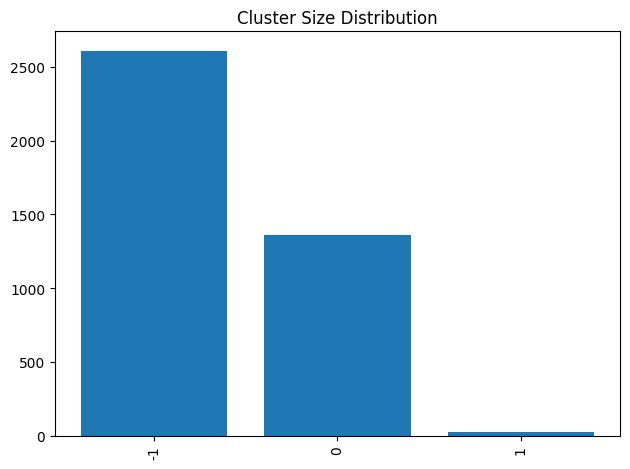

In [11]:
# Cluster size distribution (by assigned label)
from collections import Counter
cl_counts = Counter(meta["labels"])
labels_, counts_ = zip(*sorted(cl_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure()
plt.bar(range(len(labels_)), counts_)
plt.xticks(range(len(labels_)), labels_, rotation=90)
plt.title("Cluster Size Distribution")
plt.tight_layout()
plt.show()

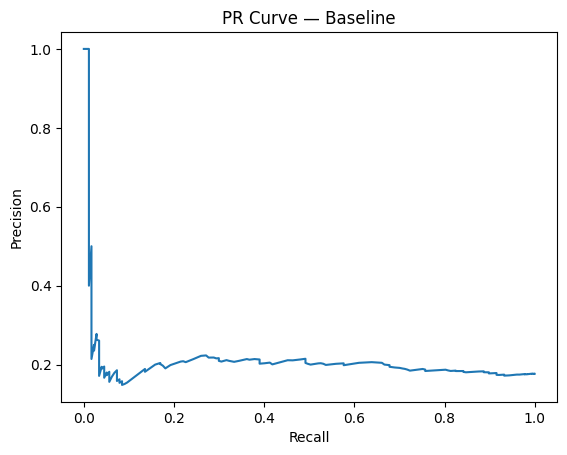

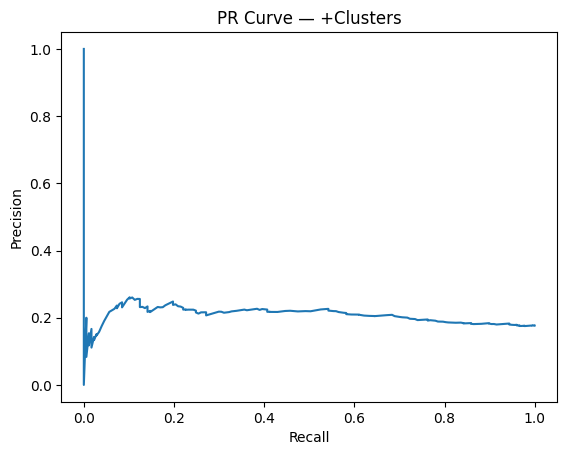

In [12]:
# PR curve comparison
plot_pr_curve(y_test, prob_base, title="PR Curve — Baseline")
plot_pr_curve(y_test_full, prob_full, title="PR Curve — +Clusters")

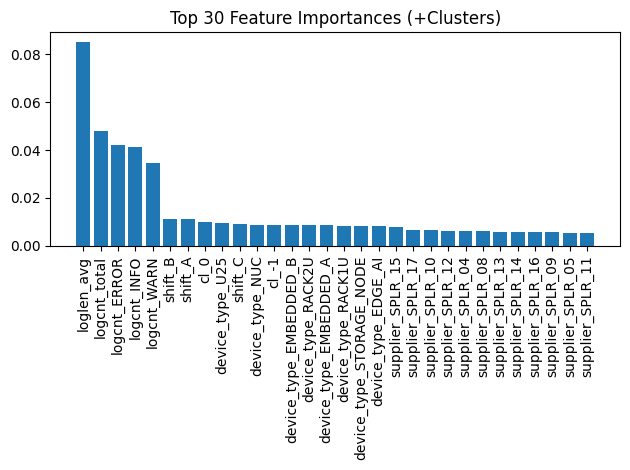

In [13]:
# Feature importances for +Clusters model
# Extract feature names from preprocessing
prep = pipe_full.named_steps["prep"]
rf_model = pipe_full.named_steps["rf"]

# Safely recover OHE feature names
def get_feature_names(preprocessor, input_cols):
    # ColumnTransformer with transformers ("num","cat")
    out = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if hasattr(trans, "named_steps"):
            last = list(trans.named_steps.values())[-1]
            if hasattr(last, "get_feature_names_out"):
                # sklearn >= 1.0
                try:
                    out.extend(last.get_feature_names_out(cols))
                except:
                    out.extend([f"{name}__{c}" for c in cols])
            else:
                out.extend([f"{name}__{c}" for c in cols])
        else:
            # SimpleImputer only
            out.extend(cols)
    return list(out)

feature_names_prep = get_feature_names(prep, train_full.columns.tolist())
plot_feature_importance(rf_model, feature_names_prep, top=30, title="Top 30 Feature Importances (+Clusters)")

Saved feature matrix -> data/processed/features_merged.csv


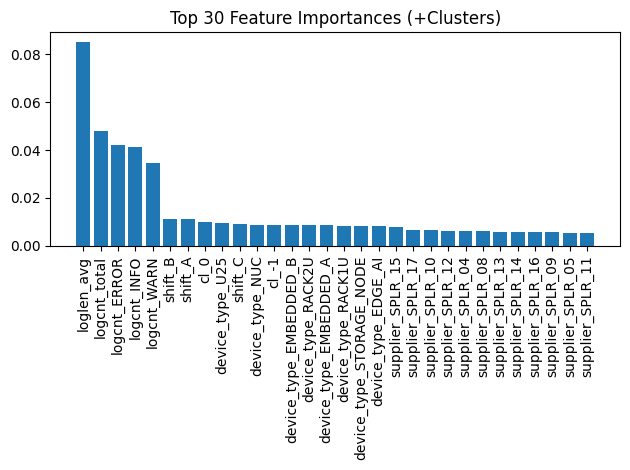

In [14]:
# Save merged features for later reuse
out_path = PROC_DIR / "features_merged.csv"
feat_merged.assign(failure_label=y).to_csv(out_path, index=False)
print("Saved feature matrix ->", out_path)

prep = pipe_full.named_steps["prep"]
rf_model = pipe_full.named_steps["rf"]
feature_names_prep = get_feature_names(prep, train_full.columns.tolist())
plot_feature_importance(rf_model, feature_names_prep, top=30, title="Top 30 Feature Importances (+Clusters)")

### Appendix — Re‑run helper
Use the cell below to quickly re‑run the end‑to‑end assembly with alternate parameters.

In [15]:
def rerun_pipeline(
    ngram_range=NGRAM_RANGE, min_df=MIN_DF, max_features=MAX_FEATURES,
    use_hdb=USE_HDBSCAN, hdb_min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE, hdb_min_samples=HDBSCAN_MIN_SAMPLES,
    dbscan_eps=DBSCAN_EPS, dbscan_min_samples=DBSCAN_MIN_SAMPLES, top_k_clusters=TOP_K_CLUSTERS,
    include_log_stats=INCLUDE_LOG_STATS, seed=RANDOM_SEED,
    test_size=TEST_SIZE, val_size=VAL_SIZE
):
    feat_merged, y, preproc, meta = assemble_features(
        wo, logs, sw,
        ngram_range=ngram_range, min_df=min_df, max_features=max_features,
        use_hdb=use_hdb, hdb_min_cluster_size=hdb_min_cluster_size, hdb_min_samples=hdb_min_samples,
        dbscan_eps=dbscan_eps, dbscan_min_samples=dbscan_min_samples, top_k_clusters=top_k_clusters,
        include_log_stats=include_log_stats, seed=seed
    )
    (train_full, y_train, _), _, (test_full, y_test, _) = split_xy(feat_merged, y, test_size=test_size, val_size=val_size, seed=seed)
    model = Pipeline(steps=[("prep", preproc), ("rf", make_rf(random_state=seed))])
    model.fit(train_full, y_train)
    prob = model.predict_proba(test_full)[:,1]
    pred = (prob >= 0.5).astype(int)
    metrics = evaluate_binary(y_test, prob, pred)
    return feat_merged, y, preproc, meta, model, metrics

In [17]:
import pandas as pd
assign = pd.read_csv("data/processed/cluster_assignments.csv")
df = pd.DataFrame({"work_order_id": feat_merged["work_order_id"], "y": y})
tab = assign.merge(df, on="work_order_id").groupby("cluster").y.agg(['mean','count']).sort_values('mean', ascending=False)
print(tab.head(15), "\nNoise rate:", (assign.cluster==-1).mean())


             mean  count
cluster                 
 1       0.307692     26
-1       0.191498   2611
 0       0.147469   1363 
Noise rate: 0.65275
